# EDA for Gas Fees - V2

In this notebook we perform Exploratory Data Analysis (EDA) on FIL's gas fee mechanism. The goal is to observe the gas fee as a signal and attempt to understand what may be driving it. 


### Next steps from Filecoin sync 6-29-2021:
* ZX next steps: Spikes in burn and base fee movement might be a lag. What is the leading indicator?
* Take different data aggregations instead of hourly. One week of data at 30 secs, for instance. 
* Look at a combination of messages.
* From ZX: bad configuration file not from the code but a miner. Spamming the chain on June 3rd, a protective mechanism protects the chain
* Explore weekly spikes - FT for periodic trend
* Check for time-varying volatility. Compare to message types
* Introduce exogenous variables such as delta network power (chain_powers, chain_economics, chain_rewards). Use state root and parent state root to combine, height if not available




Questions to be answered in this notebook:
* Understand data we have by performing a data baseline - event and aggregated data.
* Reverse engineer June 3 spike - what happened and why? Can we generalize what drives burning?
* Distribution of attributes of things people are willing to pay gas fees for. What types of transactions are individuals paying more for?
* Are revenues over cost?
* Create curated data signals for Digital Twin use
* Obtain message metadata, try and predict cost from it (classifier or regressor). Which attributes are mapped to smaller or larger costs? Which messages are worth paying a lot for? The question is what people are they paying for and *why*?
* Reperform Granger Causality when we have more data understanding





## Background information: What are Gas Fees? 
Note: this description is copied from the [official Filecoin documentation](https://docs.filecoin.io/about-filecoin/how-filecoin-works/#gas-fees)

Executing messages, for example by including transactions or proofs in the chain, consumes both computation and storage resources on the network. Gas is a measure of resources consumed by messages. The gas consumed by a message directly affects the cost that the sender has to pay for it to be included in a new block by a miner.

Historically in other blockchains, miners specify a GasFee in a unit of native currency and then pay the block producing miners a priority fee based on how much gas is consumed by the message. Filecoin works similarly, except an amount of the fees is burned (sent to an irrecoverable address) to compensate for the network expenditure of resources, since all nodes need to validate the messages. The idea is based on Ethereum's EIP1559.

The amount of fees burned in the Filecoin network comes given by a dynamic BaseFee which gets automatically adjusted according to the network congestion parameters (block sizes). The current value can be obtained from one of the block explorers or by inspecting the current head.

Additionally, a number of gas-related parameters are attached to each message and determine the amount of rewards that miners get. Here's an overview of the terms and concepts:

**GasUsage**: the amount of gas that a message's execution actually consumes. Current protocol does not know how much gas a message will exactly consume ahead of execution, but it can be estimated (see prices (opens new window)). GasUsage measured in units of Gas.

**BaseFee**: the amount of FIL that gets burned per unit of gas consumed for the execution of every message. It is measured in units of attoFIL/Gas.

**GasLimit**: the limit on the amount of gas that a message's execution can consume, estimated and specified by a message sender. It is measured in units of Gas. The sum of GasLimit for all messages included in a block must not exceed the BlockGasLimit. Messages will fail to execute if they run out of Gas, and any effects of the execution will be reverted.

**GasFeeCap**: the maximum token amount that a sender is willing to pay per GasUnit for including a message in a block. It is measured in units of attoFIL/Gas. A message sender must have a minimum balance of GasFeeCap * GasLimit when sending a message, even though not all of that will be consumed. GasFeeCap can serve as a safeguard against high, unexpected BaseFee fluctuations.

**GasPremium**: a priority fee that is paid to the block-producing miner. This is capped by GasFeeCap. The BaseFee has a higher priority. It is measured in units of attoFIL/Gas and can be as low as 1 attoFIL/Gas.

**Overestimation burn**: an additional amount of gas to burn that grows larger when the difference between GasLimit and GasUsage is large. 

The total cost of a message for a sender will be:

* GasUsage * BaseFee FIL (burned) +
* GasLimit * GasPremium FIL (miner's reward) +
* OverEstimationBurn * BaseFee FIL

An important detail is that a message will always pay the burn fee, regardless of the GasFeeCap used. Thus, a low GasFeeCap may result in a reduced GasPremium or even a negative one! In that case, the miners that include a message will have to pay the needed amounts out of their own pockets, which means they are unlikely to include such messages in new blocks.

Filecoin implementations may choose the heuristics of how their miners select messages for inclusion in new blocks, but they will usually attempt to maximize the miner's rewards.


## Data Resources
* https://hackmd.io/5leND7tITX--5NJsFCJyow # Existing Sentinel queries 
* https://github.com/filecoin-project/sentinel/blob/master/docs/sentinel_tables_purpose.csv # Sentinel Tables Purpose


### Sentinel Diagram 
![](sentinel_diagram.png)

In [16]:
# import libraries
from sqlalchemy import create_engine
import pandas as pd
from datetime import datetime
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

%matplotlib inline

In [5]:
# load connection string
CONN_STRING_PATH = 'sentinel_conn_string_andrew.txt'

with open(CONN_STRING_PATH, 'r') as fid:
    conn_string = fid.read()
    
# create database connection.
connection = create_engine(conn_string, pool_recycle=3600).connect()


Exception during reset or similar
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sqlalchemy/pool/base.py", line 697, in _finalize_fairy
    fairy._reset(pool)
  File "/opt/anaconda3/lib/python3.8/site-packages/sqlalchemy/pool/base.py", line 893, in _reset
    pool._dialect.do_rollback(self)
  File "/opt/anaconda3/lib/python3.8/site-packages/sqlalchemy/engine/default.py", line 543, in do_rollback
    dbapi_connection.rollback()
psycopg2.errors.IdleInTransactionSessionTimeout: terminating connection due to idle-in-transaction timeout
SSL connection has been closed unexpectedly



## Data EDA

Below we download hourly averages from the `messages` and `mesage_gas_economy` table from May 1st, 2021 to present (last refreshed 6/28/2021). After downloading the data, we few the first and lasts 5 rows, and perform basic statistics on the data.


### Data Dictionary - coped from [Sentinel's Data Dictionary](https://github.com/filecoin-project/sentinel/blob/master/docs/db.md)
## `message_gas_economy`
Gas economics for all messages in all blocks at each epoch.

|Name|Type|Nullable|Description|
|---|---|---|---|
|`base_fee`|`double precision`|NO|The set price per unit of gas (measured in attoFIL/gas unit) to be burned (sent to an unrecoverable address) for every message execution.|
|`base_fee_change_log`|`double precision`|NO|The logarithm of the change between new and old base fee.|
|`gas_capacity_ratio`|`double precision`|YES|The gas_limit_unique_total / target gas limit total for all blocks.|
|`gas_fill_ratio`|`double precision`|YES|The gas_limit_total / target gas limit total for all blocks.|
|`gas_limit_total`|`bigint`|NO|The sum of all the gas limits.|
|`gas_limit_unique_total`|`bigint`|YES|The sum of all the gas limits of unique messages.|
|`gas_waste_ratio`|`double precision`|YES|(gas_limit_total - gas_limit_unique_total) / target gas limit total for all blocks.|
|`height`|`bigint`|NO|Epoch these economics apply to.|
|`state_root`|`text`|NO|CID of the parent state root at this epoch.|


## `messages`
Validated on-chain messages by their CID and their metadata.

|Name|Type|Nullable|Description|
|---|---|---|---|
|`cid`|`text`|NO|CID of the message.|
|`from`|`text`|NO|Address of the actor that sent the message.|
|`gas_fee_cap`|`text`|NO|The maximum price that the message sender is willing to pay per unit of gas.|
|`gas_limit`|`bigint`|NO|-|
|`gas_premium`|`text`|NO|The price per unit of gas (measured in attoFIL/gas) that the message sender is willing to pay (on top of the BaseFee) to "tip" the miner that will include this message in a block.|
|`height`|`bigint`|NO|Epoch this message was executed at.|
|`method`|`bigint`|YES|The method number invoked on the recipient actor. Only unique to the actor the method is being invoked on. A method number of 0 is a plain token transfer - no method exectution.|
|`nonce`|`bigint`|NO|The message nonce, which protects against duplicate messages and multiple messages with the same values.|
|`size_bytes`|`bigint`|NO|Size of the serialized message in bytes.|
|`to`|`text`|NO|Address of the actor that received the message.|
|`value`|`text`|NO|Amount of FIL (in attoFIL) transferred by this message.|


In [ ]:
Use state root and parent state root to combine, height if not available

In [8]:
QUERY = """
SELECT 
to_timestamp(height_to_unix(m.height)) as timestamp,
m.from,
m.gas_fee_cap,
m.method,
m.to
FROM messages m
WHERE
to_timestamp(height_to_unix(m.height)) BETWEEN '2021-06-02' AND '2021-06-05'
"""
messages = (pd.read_sql(QUERY, connection))


## Analyze Message meta data

In [9]:
messages.describe()

,method
count,4.644615e+06
mean,6.318362e+00
std,1.078328e+00
min,0.000000e+00
25%,6.000000e+00
50%,6.000000e+00
75%,7.000000e+00
max,2.300000e+01


In [11]:
messages['method'].value_counts()

6     2197377
7     2173655
5      170165
0       85902
2       10074
11       3792
4        1653
16       1402
3         337
9         136
23         58
20         28
18         17
21         14
8           4
22          1
Name: method, dtype: int64

In [12]:
messages['from'].value_counts()

f3qcmmkbobbp6ed4psyvny6zsia5v32dlxnvpfgxsvpjtaptjyuapmd3i5zr2353fqe7a2kowceis65iyjzsoq    88709
f3vqd3cenprn6xdt73igrjukq5a7nh5rgjgajw5iev6snhv76o2sqmlgzbvq4vyje5ulrjriicsln6tz3xgimq    68142
f3ucq7fmnfoa3jsum7qjoeyz2gflwdcq4g44eiojll6lnlqe7wbx24tjvg5v4zfniwjk6cuo2l3mceq2we6kea    63760
f3sfemh6sz2zkrei23ra4fng4kjqr5tek4bleyxbrvcyndxvutmep27orixnjunm5cwqq25x4xlbup3jqbt3ua    52469
f3q2crv5dhkobq7y7fzgmfot7dtxbwe26r6wzp7ny43f5233tdzvzabdup2knjc46g6ogfi5zesn34byxhjaha    51858
                                                                                          ...  
f1wnw4glvtxctxsu77bppirvkj4mchklj5xhs5vai                                                     1
f1jyaerwe4jbgeubeklq754nryoygxzcovqnjhlwi                                                     1
f1z5e7ldxef275t5dbja7a7a4qhno22dwsigh5ksa                                                     1
f1lebl3jzeamxeo6hcncshaidf46fqcojrfxedzsa                                                     1
f1cfbpq2jb6luec7x676r3pcybgeflnp7efnp5f7

In [13]:
messages['to'].value_counts()

f0755327                                     88856
f0764901                                     88802
f0688165                                     74596
f0463143                                     68439
f0724216                                     66924
                                             ...  
f1ussp25a3is2no7fc3remkkc6f7gogrnvgbpdmei        1
f1qxoc7hsj7ij75iz6cwwmklttjga5lvi4svzmn5i        1
f1bskb6jxhanlhorbdbvmlbbzldvrqtqr4hem4lgq        1
f1yt4kmxkure52zqkg3sm7x6jmcxnbvpy6iwze3ja        1
f1gehachl7u7dqpgp63iapx7gifpkluif4klad6wq        1
Name: to, Length: 37333, dtype: int64

<AxesSubplot:xlabel='timestamp'>

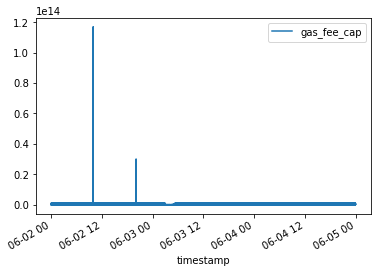

In [18]:
messages['gas_fee_cap'] = messages['gas_fee_cap'].astype(float)
messages.plot(x='timestamp',y='gas_fee_cap')